### Mean Field Model

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from scipy.ndimage import label

sys.path.append(os.path.abspath('..')) 
from models.mean_field import MeanFieldModel
from models.CA import CA, PP

# Enable inline plotting
%matplotlib inline

def set_project_style():
    """Sets a unified Seaborn style for all project visualizations."""
    # Use a professional whitegrid style with high-resolution settings
    sns.set_theme(style="whitegrid", context="paper", palette="colorblind")
    plt.rcParams.update({
        'font.family': 'serif',
        'figure.figsize': (10, 7),
        'axes.titlesize': 16,
        'axes.labelsize': 14,
        'legend.fontsize': 12,
        'legend.frameon': True,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'lines.linewidth': 2.2,
        'figure.dpi': 150
    })

set_project_style()

In [3]:
mf = MeanFieldModel(
    birth=0.2,
    consumption=0.8,
    predator_death=0.045,
    conversion=1.0,
    prey_competition=0.1,
    predator_competition=0.05
)

# Shared range for prey death rate sweeps (d_r)
d_r_values = np.linspace(0.001, 0.15, 100)

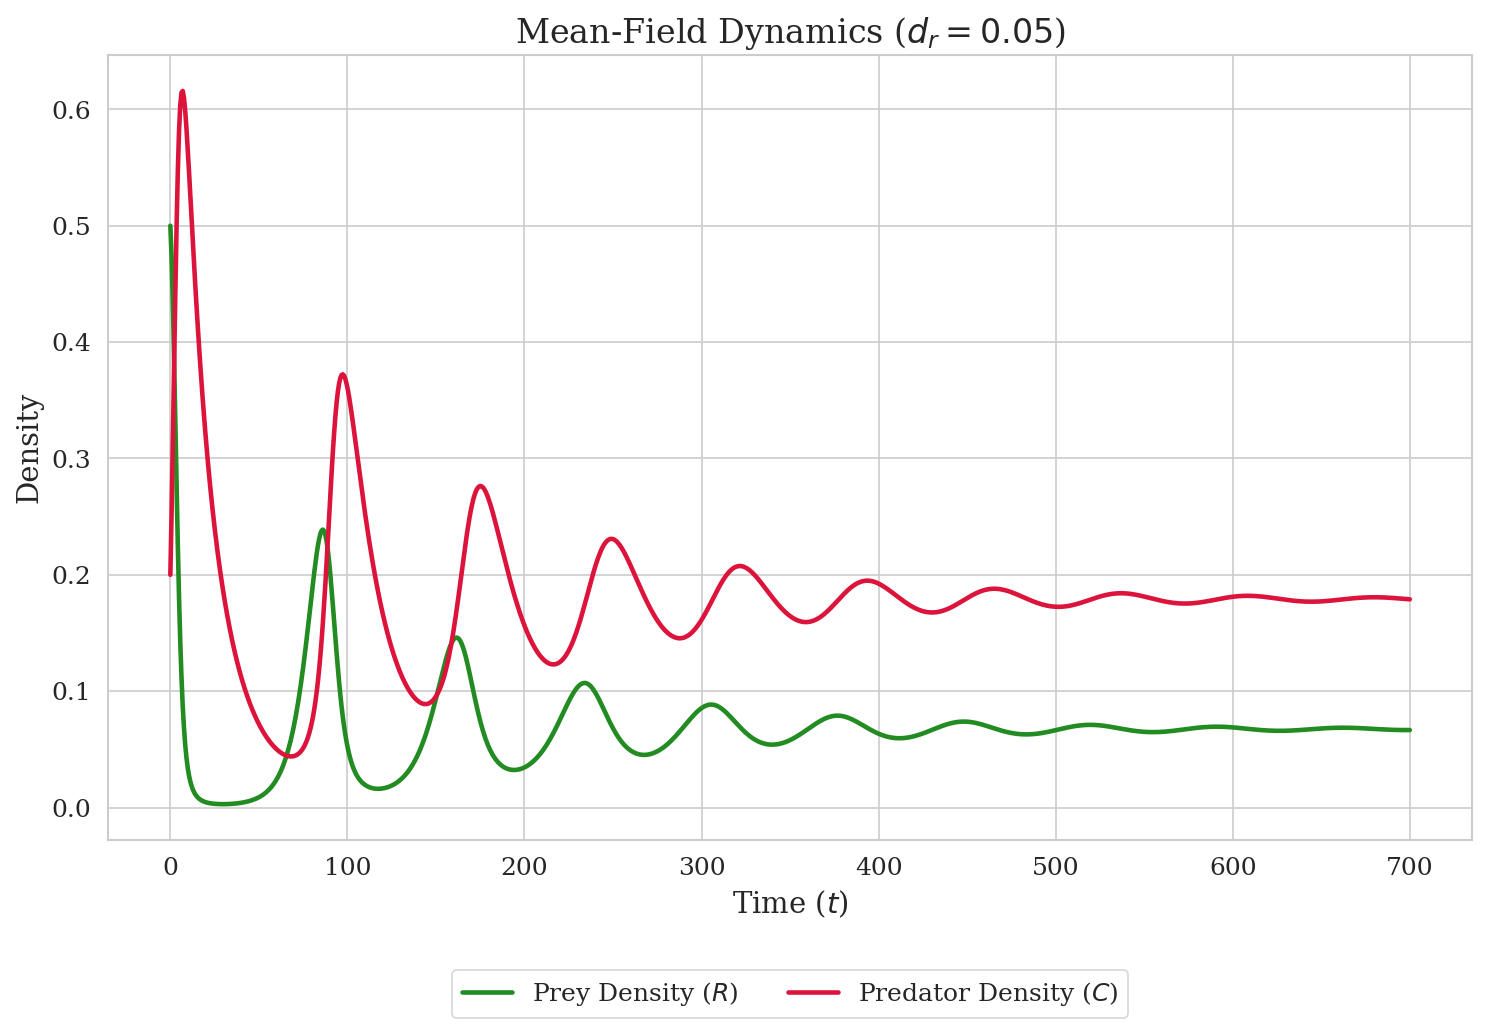

In [4]:
def plot_time_series_baseline(t, sol, title='Mean-Field Dynamics ($d_r = 0.05$)'):
    fig, ax = plt.subplots()
    ax.plot(t, sol[:, 0], color='forestgreen', label='Prey Density ($R$)')
    ax.plot(t, sol[:, 1], color='crimson', label='Predator Density ($C$)')
    
    ax.set_xlabel('Time ($t$)')
    ax.set_ylabel('Density')
    ax.set_title(title)
    # Legend at the bottom
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
    plt.tight_layout()
    return ax

t, sol = mf.solve(prey_death=0.05, R0=0.5, C0=0.2, t_max=500)
plot_time_series_baseline(t, sol)
plt.show()

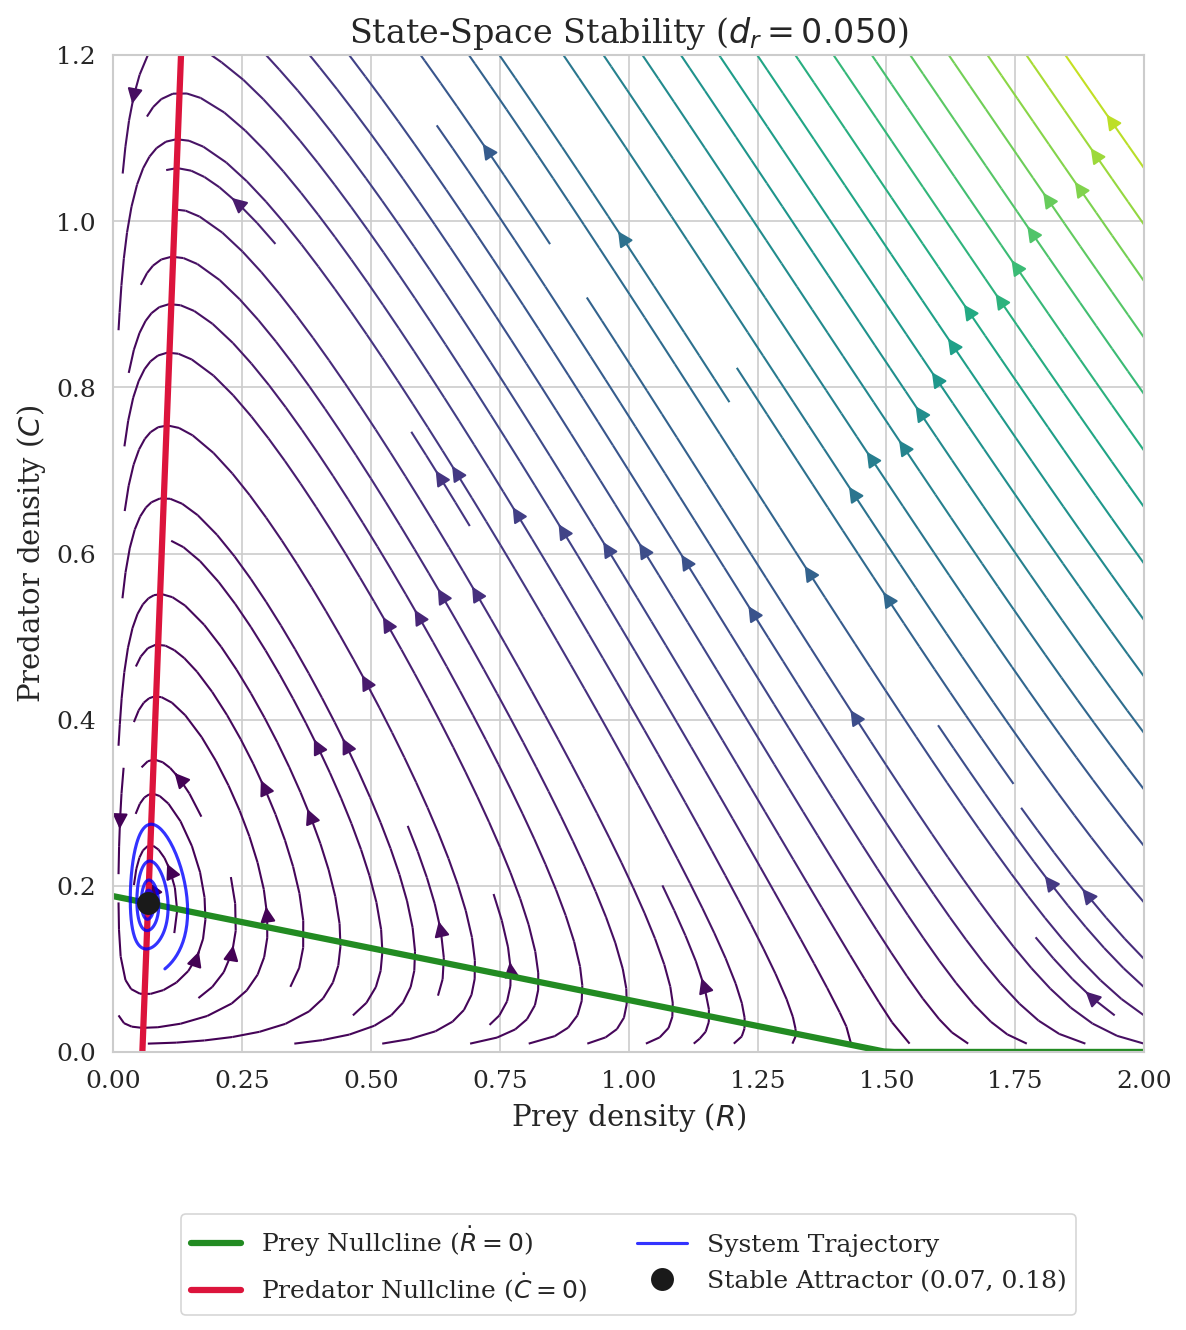

In [5]:
def plot_phase_portrait_master(model, prey_death, R_range=(0, 2), C_range=(0, 1.2)):
    fig, ax = plt.subplots(figsize=(8, 9))
    R_grid, C_grid = np.meshgrid(np.linspace(0.01, R_range[1], 25), 
                                 np.linspace(0.01, C_range[1], 25))
    
    # Vector Field with magnitude coloring
    dR, dC = model.ode_system([R_grid, C_grid], 0, prey_death)
    magnitude = np.sqrt(dR**2 + dC**2)
    ax.streamplot(R_grid, C_grid, dR, dC, color=magnitude, cmap='viridis', 
                  linewidth=1, density=1.2, arrowsize=1.5)
    
    # Nullclines
    r_net = model.birth - prey_death
    R_fine = np.linspace(0, R_range[1], 100)
    ax.plot(R_fine, np.maximum((r_net - model.prey_competition * R_fine) / model.consumption, 0), 
            color='forestgreen', lw=3, label=r'Prey Nullcline ($\dot{R}=0$)')
    
    C_fine = np.linspace(0, C_range[1], 100)
    ax.plot((model.predator_death + model.predator_competition * C_fine) / model.pred_benifit, 
            C_fine, color='crimson', lw=3, label=r'Predator Nullcline ($\dot{C}=0$)')
    
    # System Trajectory (The Spiral)
    _, sol_traj = model.solve(prey_death, R0=0.1, C0=0.1, t_max=400)
    ax.plot(sol_traj[:, 0], sol_traj[:, 1], color='blue', lw=1.5, alpha=0.8, label='System Trajectory')
    
    # Equilibrium Point
    R_eq, C_eq = model.equilibrium(prey_death)
    ax.plot(R_eq, C_eq, 'ko', markersize=10, label=f'Stable Attractor ({R_eq:.2f}, {C_eq:.2f})', zorder=10)
    
    ax.set_xlabel('Prey density ($R$)')
    ax.set_ylabel('Predator density ($C$)')
    ax.set_title(f'State-Space Stability ($d_r = {prey_death:.3f}$)')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
    ax.set_xlim(R_range); ax.set_ylim(C_range)
    plt.tight_layout()
    return ax

plot_phase_portrait_master(mf, prey_death=0.05)
plt.show()

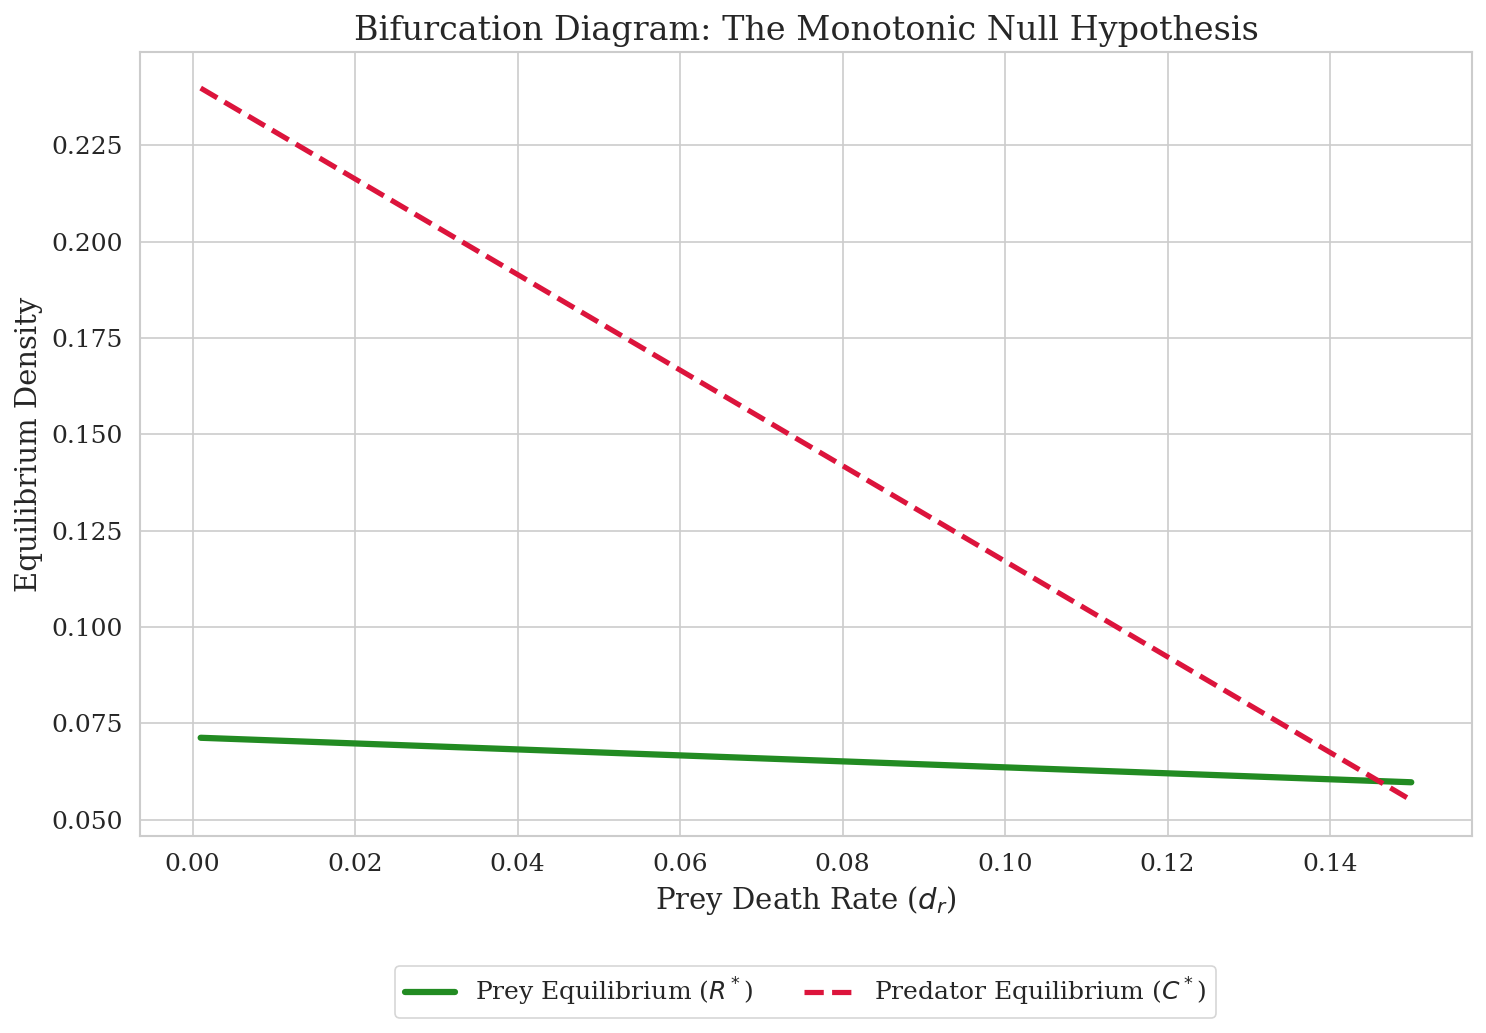

In [6]:
def plot_monotonicity_baseline(d_r_vals, R_mf, C_mf):
    fig, ax = plt.subplots()
    ax.plot(d_r_vals, R_mf, color='forestgreen', lw=3, label='Prey Equilibrium ($R^*$)')
    ax.plot(d_r_vals, C_mf, color='crimson', ls='--', lw=2.5, label='Predator Equilibrium ($C^*$)')
    
    ax.set_title("Bifurcation Diagram: The Monotonic Null Hypothesis")
    ax.set_xlabel('Prey Death Rate ($d_r$)')
    ax.set_ylabel('Equilibrium Density')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
    plt.tight_layout()
    return ax

results = mf.sweep_death_rate(d_r_values, method='analytical')
plot_monotonicity_baseline(d_r_values, results['R_eq'], results['C_eq'])
plt.show()

### Predator-Prey Model Plots

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


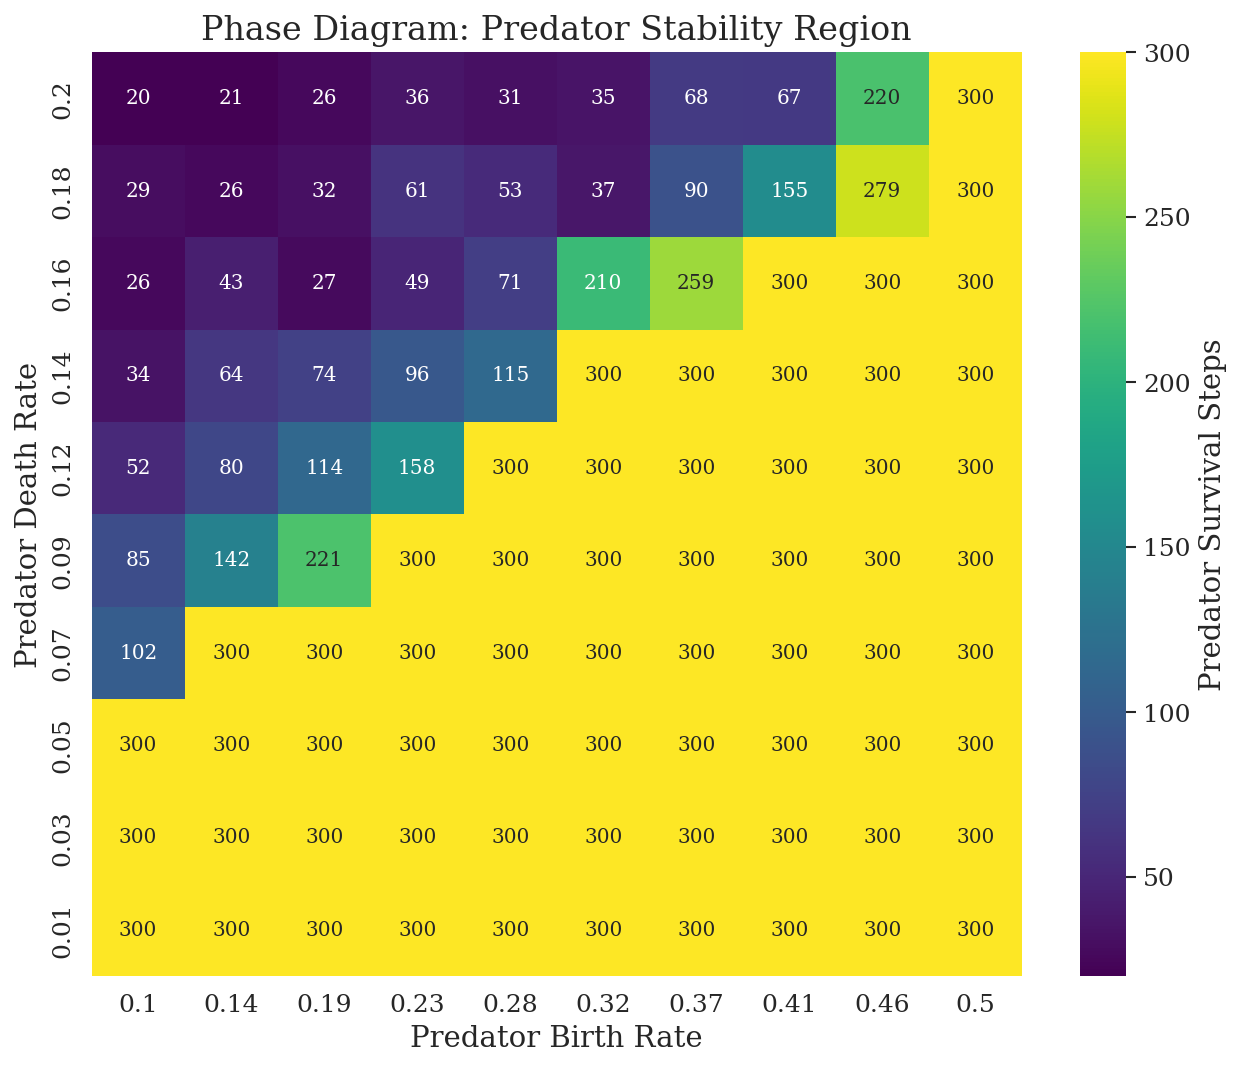

In [12]:
from tqdm import tqdm  # Progress bar

def run_phase_sweep(rows=50, cols=50, steps=300):
    pred_death_vals = np.linspace(0.01, 0.2, 10)  # y-axis
    pred_birth_vals = np.linspace(0.1, 0.5, 10)   # x-axis
    
    stability_grid = np.zeros((len(pred_death_vals), len(pred_birth_vals)))
    
    for i, p_death in enumerate(tqdm(pred_death_vals)):
        for j, p_birth in enumerate(pred_birth_vals):
            params = {
                "prey_birth": 0.25,
                "prey_death": 0.05,
                "predator_death": p_death,
                "predator_birth": p_birth
            }
            
            model = PP(rows, cols, densities=(0.2, 0.1), params=params, seed=42)
            
            survival_score = 0
            for t in range(steps):
                model.update()
                n_pred = np.sum(model.grid == 2)
                
                if n_pred > 5: # Threshold to ignore stray survivors
                    survival_score += 1
                else:
                    break # Extinction occurred
            
            stability_grid[i, j] = survival_score
    plt.figure(figsize=(10, 8))
    
    # Use seaborn for a nice heatmap
    ax = sns.heatmap(stability_grid, 
                     xticklabels=np.round(pred_birth_vals, 2),
                     yticklabels=np.round(pred_death_vals, 2),
                     cmap="viridis", 
                     annot=True, 
                     fmt=".0f",
                     cbar_kws={'label': 'Predator Survival Steps'})
    
    ax.invert_yaxis() 
    plt.title("Phase Diagram: Predator Stability Region")
    plt.xlabel("Predator Birth Rate")
    plt.ylabel("Predator Death Rate")
    plt.show()

run_phase_sweep()

In [ ]:
GRID_SIZE = 100
DENSITIES = (0.30, 0.15)

N_REPLICATES = 25
N_STEPS = 500
WARMUP_STEPS = 150  # Increased warmup